### Pneumonia Detection
In this kernel, I will be exploring pneumonia detection using the **fast.ai library** with my current skills. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/chest_xray/chest_xray"))

# Any results you write to the current directory are saved as output.

['test', 'train', 'val', '.DS_Store']


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [3]:
# We define a path to our data in the work directory
data_dir = Path('../input/chest_xray/chest_xray')

# Directories for all our data groups
train_dir = Path('../input/chest_xray/chest_xray/train')
test_dir = Path('../input/chest_xray/chest_xray/test')
val_dir = Path('../input/chest_xray/chest_xray/val')

print(os.listdir('../input/chest_xray/chest_xray/train'))

['NORMAL', 'PNEUMONIA', '.DS_Store']


In [4]:
# Our classes are normal and pneumonia
classes = ['normal','pneumonia']


In [5]:
# Create an ImageDataBunch object from the training directory
# help(ImageDataBunch)
np.random.seed(42)
train_data = ImageDataBunch.from_folder(train_dir,train=".",valid_pct=0.2,
                                       ds_tfms=get_transforms(),size=224,
                                        num_workers=4).normalize(imagenet_stats)

(['NORMAL', 'PNEUMONIA'], 2, 4173, 1043)

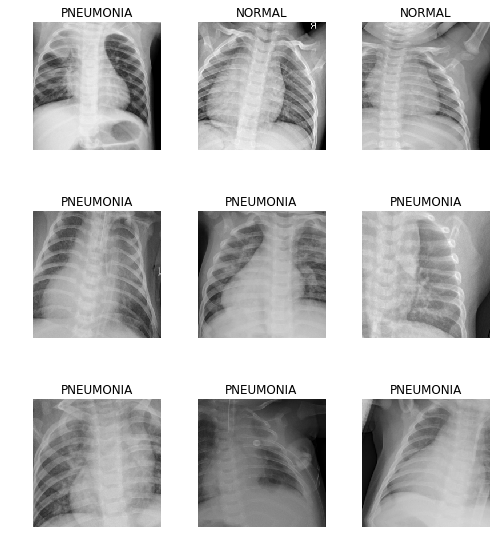

In [6]:
# Check our data classes and visualise some data.
train_data.classes

train_data.show_batch(rows=3, figsize=(7,8))

train_data.classes, train_data.c, len(train_data.train_ds), len(train_data.valid_ds)

In [7]:
# Model Training
# Create a learner using resnet34
learn = cnn_learner(train_data,models.resnet34,
                    metrics=[error_rate,Recall(average='macro'),
                             Precision(average='macro')],model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 19468214.13it/s]


In [8]:
# Dry run for 4 epochs
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,recall,precision,time
0,0.376138,0.179354,0.060403,0.942122,0.914627,03:26
1,0.222750,0.163311,0.058485,0.943444,0.917328,03:34
2,0.162260,0.175627,0.059444,0.952510,0.912665,03:32
3,0.143344,0.139599,0.052733,0.956059,0.921934,03:34


In [9]:
# We save our current weights to now experiment and fine tune our CNN
learn.save('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


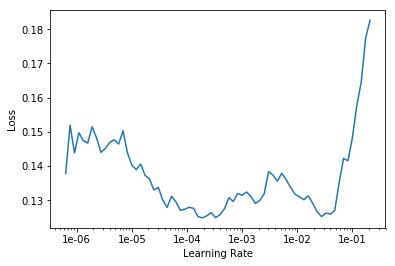

In [10]:
# Investigate our learning rate to finetune our training
learn.lr_find()
learn.recorder.plot()

We will choose a learning rate before the Loss begins to decrease. In this case, 1e-06 to 1e-05

In [11]:
lr = slice(1e-6,1e-5)

In [12]:
# Unfreeze our learner and begin to train the deeper layers of the CNN
learn.unfreeze()
learn.fit_one_cycle(4,max_lr=lr)

epoch,train_loss,valid_loss,error_rate,recall,precision,time
0,0.122090,0.143881,0.050815,0.957382,0.924566,03:33
1,0.129821,0.135689,0.050815,0.955220,0.925436,03:33
2,0.120405,0.120651,0.046021,0.958527,0.932287,03:33
3,0.114694,0.130115,0.046021,0.960688,0.931289,03:33


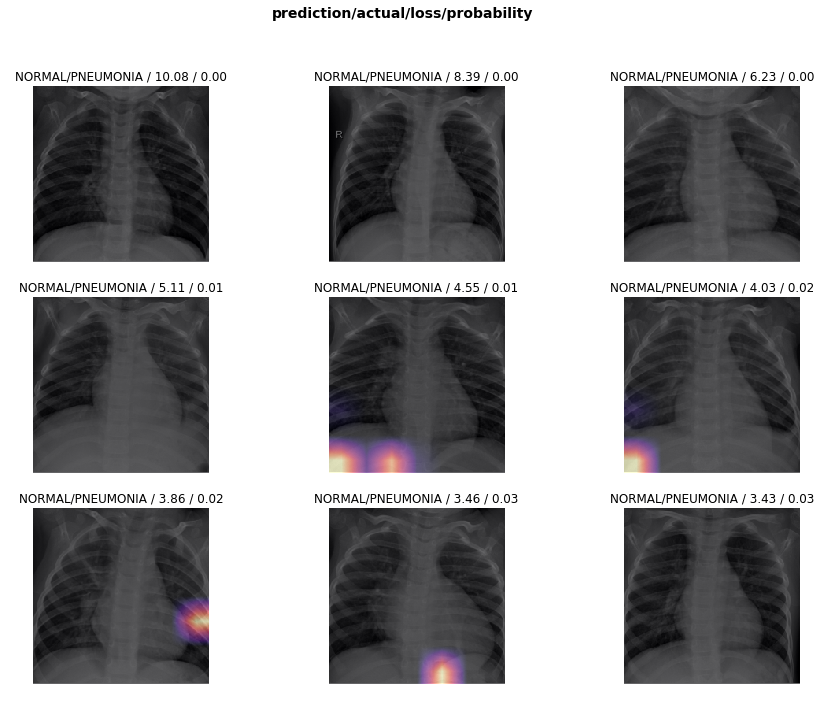

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(15,11))

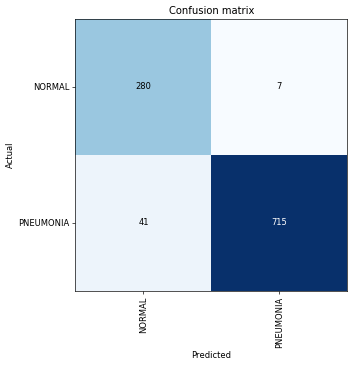

In [14]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [15]:
# Save new weights for any further experimentation.
learn.save('stage-2')

**Some thoughts and closing remarks:**

Currently this kernel only utilises the training data set. I have yet to figure out how to use the test data set and check against it to evaluate the success of this model. Also, the validation set is quite small, so I chose 20% of the training set as a validation data set. 

I am quite happy with the results as the top-voted kernel for this dataset, posted a year ago, has been outperformed by this model! This also is an eye opening experience of how far ML and technologies are progressing as I am using fast.ai and the top kernel used Sklearn and Keras. Fast.ai seems very powerful, and I hope that it only gets better in a few more years. 

But taking a step back and thinking about the performance of a model working in a scenario like this; it is much better for the model to be predict **more false positives than false negatives.** If it were to be used in a production environment, as patients who do actually have pneumonia will be ignored. If I was a patient, I would rather be told that I had pneumonia and had a false diagnosis than the opposite. 

From another perspective however, this could be a very good screening method for a hospital facing large numbers of diagnoses. It is usually the case that patients would be directed to take an xray to determine the presence of a sickness like this and usually they are sent with high confidence. Thus, if presented with a high volume of xrays, a large portion of patients would actually have pneuomonia.

**For the future:**
* I may revisit this problem once I am better equipped to retest my model and perhaps use another CNN with this dataset. 
* Some data augmentation to further accentuate the differences between the two classes as there is a fairly clear difference in opacity of the chest cavity.
* More data augmentation to create a model utilising higher resolutions of the data set.

**What I learnt about my own progress:**
I need to sharpen up the small key skills such as data manipulation and paths for utilising this data, I had an initial struggle to access the data set but overcame it with some help.
